# Oversampling Modeling Experiments

+ Goal: To improve model performance metrics through oversampling
+ Will implement random oversampling to hopefully boost performance
+ Will conduct xgboosting after oversampling

In [9]:

# import necessary packages
import pandas as pd
import numpy as np

# grab most up-to-date df
df = pd.read_feather('../JacobSubset/filtered/mut/final-filtered-mut-netphos.feather')

# format answer column
df['answer'] = df['answer'].apply(lambda x: 1 if str(x).strip().upper() == 'YES' else 0).astype(int)
print(df['answer'].value_counts())

# preview 
df.head()


answer
0    40544
1     2880
Name: count, dtype: int64


,Gene,wt,pos,mut,context,score,kinase,answer
0,ABCB1,S,35,N,KPTVSNFSM,0.470,CaM-II,0
1,ABCB1,S,35,N,KPTVSNFSM,0.469,PKA,0
2,ABCB1,S,35,N,KPTVSNFSM,0.440,GSK3,0
3,ABCB1,S,35,N,KPTVSNFSM,0.413,PKG,0
4,ABCB1,S,35,N,KPTVSNFSM,0.365,CKI,0


In [25]:
# Encode and remove unnecessary variables
df_smote = df.drop(columns=['score'])

# initialize smote df
X_smote = df_smote[['wt', 'mut', 'kinase', 'pos']]
y = df_smote['answer']

# keep track of the indices of categorical variables for SMOTENC
categorical_indices = [0, 1, 2]

X_smote.head()

,wt,mut,kinase,pos
0,S,N,CaM-II,35
1,S,N,PKA,35
2,S,N,GSK3,35
3,S,N,PKG,35
4,S,N,CKI,35


## Begin Oversampling

Lets try SMOTE-NC which is a variation of SMOTE that can effectively oversample the minority class with dummy variables.

In [ ]:

# import oversampling packages
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split

smote_nc = SMOTENC(categorical_features=categorical_indices, random_state=617)
X_resampled, y_resampled = smote_nc.fit_resample(X_smote, y)

X_res_smote_enc = pd.get_dummies(X_resampled, columns=['wt', 'mut', 'kinase'], drop_first=True)

# test train split data
X_train, X_test, y_train, y_test = train_test_split(
    X_res_smote_enc, y_resampled, test_size=0.2, random_state=617, stratify=y_resampled
)





/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


## Conduct Random Forest

In [27]:

# import necessary packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# initialize model
rf_model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=617
)

# train model
rf_model.fit(X_train, y_train)

# make predictions
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1]

# evaluate model
print('Classification Report:', classification_report(y_test, y_pred))
print('ROC AUC Score:', roc_auc_score(y_test, y_prob))


Classification Report:               precision    recall  f1-score   support

           0       0.85      0.81      0.83      8109
           1       0.82      0.85      0.84      8109

    accuracy                           0.83     16218
   macro avg       0.83      0.83      0.83     16218
weighted avg       0.83      0.83      0.83     16218

ROC AUC Score: 0.9099328849384588


+ Model is suspiciously high
    + Most likely caused by 'pos' causing data leakage
    + Had to include pos to conduct SMOTENC
    + Find out the culprit through feature importance
+ Next we will try simple oversampling without pos
+ Then conduct xgboost modeling

In [28]:

# create new df without pos
X_res_enc = pd.get_dummies(X_resampled, columns=['wt', 'mut', 'kinase'], drop_first=True)
X_res_enc = X_res_enc.drop(columns=['pos'])

# split data
X_train, X_test, y_train, y_test = train_test_split(
    X_res_enc, y_resampled, test_size=0.2, random_state=617, stratify=y_resampled
)

# initialize model
rf_model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=617
)

# train model
rf_model.fit(X_train, y_train)

# make predictions
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1]

# evaluate model
print('Classification Report:', classification_report(y_test, y_pred))
print('ROC AUC Score:', roc_auc_score(y_test, y_prob))


Classification Report:               precision    recall  f1-score   support

           0       0.87      0.76      0.81      8109
           1       0.79      0.89      0.84      8109

    accuracy                           0.83     16218
   macro avg       0.83      0.83      0.82     16218
weighted avg       0.83      0.83      0.82     16218

ROC AUC Score: 0.8978519807224542


+ Surprisingly after we removed 'pos' model metrics did not plummet
+ Model is now learning from the categorical features
+ Very positive metrics of recall and precision no matter the class
+ Also high ROC AUC score signaling model can confidently distinguish classes

## From here we should focus on optimizing this model with xgboost and SHAP analysis 

In [ ]:

# import xgboost
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    eval_metric='logloss',
    random_state=617
)

xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

print('Classification_report:', classification_report(y_test, y_pred_xgb))
print('ROC Score', roc_auc_score(y_test, y_prob_xgb))

[14:14:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Classification_report:               precision    recall  f1-score   support

           0       0.87      0.76      0.81      8109
           1       0.79      0.89      0.83      8109

    accuracy                           0.82     16218
   macro avg       0.83      0.82      0.82     16218
weighted avg       0.83      0.82      0.82     16218

ROC Score 0.8951676656875754


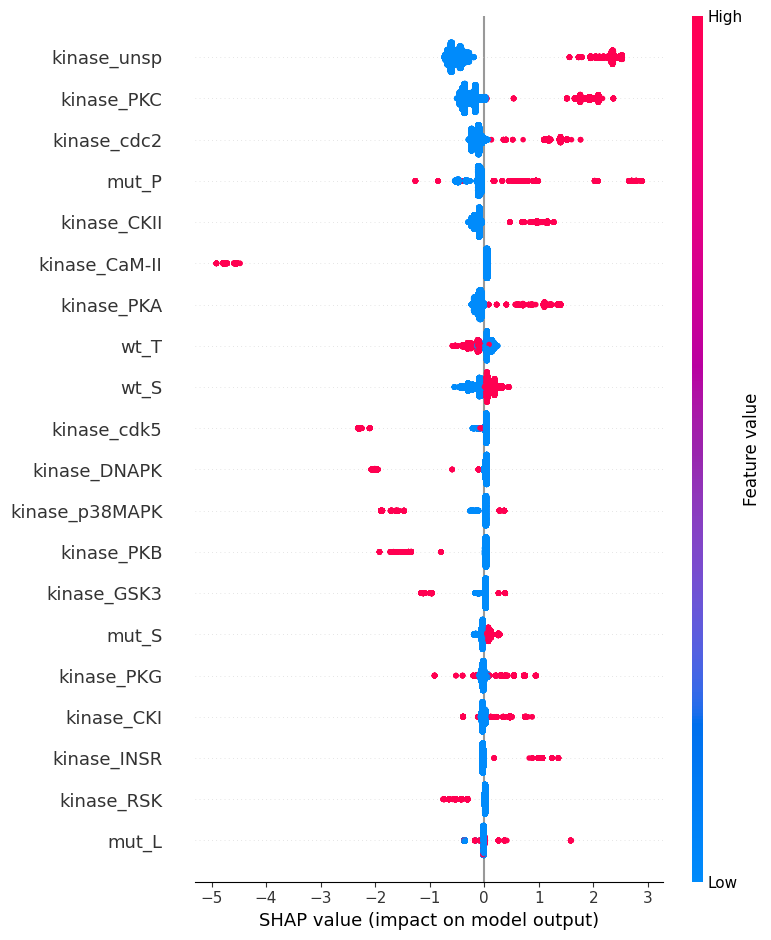

In [35]:

# import shap package
import shap 

# initialize shap explainer
explainer = shap.Explainer(xgb_model)

# fit explainer onto model then lets visualize the values
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

+ We are seeing similar behaviors from when we found each feature's coefficient
+ This is a much more insightful visualization of each features impact on 'answer'
+ Top influential features:
    + kinase_unsp - unspecified kinase = high SHAP
    + kinase_PKC - high SHAP
    + kinase_cdc2
    + mut_P - proline mutation = significant 
    + wt_T, wt_S - threonine, serine = slightly meaningful wild-types
+ From this plot we can try and form insights into combinations of mutations, kinase types, and wild-types